In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.formula.api as sm
import re

%matplotlib inline
import matplotlib.pyplot as plt

data_path = "C:/Users/SpiffyApple/Documents/USC/RaphaelBostic/LA Business Tax Reform"

# Tax Reform Models:

### Description
In this notebook, we test a few linear model specifications for our examination on the 2004 LA business tax reform. 

### Models:
1. log(price_per_sqft) ~ LA + 2005*LA + 2006*LA + ... 2012*LA and variations on time span
2. log(price_per_sqft) ~ 1_variables + rooms+unit_stories+living_area_sqft+lot_size + (census tract level fixed effects)
3. vary the distance from border parameter and re-test the above specifications
4. log(price_per_sqft) - 2_variables + pop_size + median_income + college_educatd + poverty + race + homeownership

In [2]:
## data prep:
df = pd.read_csv("/".join([data_path,"transactions_dist_cities.csv"]), low_memory=False)
df = df[df.transyear >= 1998]
df['in_la'] = df.addr_city == 'LOS ANGELES'

df.addr_city = df.addr_city.str.title()
df['combo'] = df[['city_name', 'addr_city']].apply(lambda s: "-".join(s), axis=1)

yr_dummies = pd.get_dummies(df.transyear)
yr_dummies.columns = 'yr'+yr_dummies.columns.astype(str)
df = pd.concat([df,yr_dummies],axis=1)

In [3]:
##add after 2004 dummy
df.loc[:,'after04'] = 0
df.loc[df.transyear>2004,'after04'] = 1

In [4]:
#check the number of transactions in each city per year

freq_table = df[['transyear','addr_city', 'price_per_']].groupby(['transyear', 'addr_city']).count().unstack()
freq_table.columns = freq_table.columns.droplevel(0)
with open("/".join([data_path, 'yearCitycounts.tex']), 'w+') as f:
    f.write(freq_table.to_latex())

cities_w_data4all = freq_table.columns[freq_table.apply(lambda col: col.isnull().any(), axis=0)]
freq_table[cities_w_data4all]

addr_city,Agoura Hills,Alhambra,Arcadia,Bell,Bell Gardens,Bellflower,Burbank,Carson,Commerce,Compton,...,Rosemead,San Gabriel,San Marino,Sierra Madre,Signal Hill,South El Monte,South Gate,South Pasadena,Temple City,Vernon
transyear,,,,,,,,,,,,,,,,,,,,,
1998,4.0,56.0,11.0,19.0,16.0,2.0,113.0,52.0,26.0,106.0,...,22.0,2.0,5.0,5.0,38.0,48.0,38.0,5.0,10.0,39.0
1999,NaN,57.0,21.0,31.0,21.0,4.0,127.0,59.0,50.0,174.0,...,38.0,NaN,5.0,3.0,24.0,30.0,58.0,8.0,14.0,59.0
2000,NaN,47.0,4.0,19.0,24.0,NaN,120.0,39.0,46.0,102.0,...,35.0,1.0,5.0,3.0,23.0,39.0,65.0,15.0,18.0,48.0
2001,1.0,32.0,5.0,15.0,14.0,2.0,72.0,30.0,21.0,81.0,...,33.0,2.0,5.0,4.0,33.0,19.0,66.0,11.0,13.0,31.0
2002,NaN,76.0,5.0,25.0,23.0,NaN,101.0,36.0,28.0,113.0,...,46.0,NaN,5.0,3.0,23.0,21.0,42.0,10.0,23.0,22.0
2003,1.0,40.0,NaN,20.0,14.0,2.0,99.0,21.0,22.0,99.0,...,58.0,4.0,4.0,4.0,27.0,25.0,52.0,6.0,26.0,35.0
2004,NaN,58.0,6.0,18.0,15.0,NaN,110.0,33.0,36.0,135.0,...,50.0,2.0,6.0,2.0,43.0,42.0,55.0,9.0,19.0,55.0
2005,NaN,67.0,4.0,24.0,17.0,1.0,130.0,41.0,147.0,156.0,...,38.0,2.0,5.0,5.0,13.0,42.0,68.0,14.0,16.0,67.0
2006,NaN,47.0,4.0,15.0,23.0,2.0,97.0,40.0,47.0,138.0,...,45.0,4.0,2.0,6.0,32.0,16.0,38.0,9.0,11.0,64.0


In [58]:
#construct the pairwise dummies for the datasets
pair_city_list = df.combo[df.combo.str.contains("Los Angeles")].unique() #get array of paired cities
pair_city_list = set([s+"-Los Angeles" for s in cities_w_data4all]).intersection(pair_city_list)

pair_col_titles = [re.sub("\s", "",s)[:4]+"Pair" for s in pair_city_list] #make corresponding titles

#make a dummy data frame to populate
pairDums =pd.DataFrame(np.zeros((df.shape[0],len(pair_col_titles))),columns = pair_col_titles)
pairDums.index = df.index

#populate the dummies data frame
for pair_city in pair_city_list:
    colName = re.sub("\s", "",pair_city[:4])+"Pair"
    pairDums.loc[df.addr_city.str.contains(pair_city[0]) | df.combo.str.contains("-".join(pair_city)),colName] = 1

In [59]:
df = pd.concat([df, pairDums],axis=1)

In [47]:
print("number of sales with price per sqft as 0: %d" %(df.price_per_ == 0).sum())
cols = ['transyear', 'price_per_', 'addr_city', 'val_prop','taxdelinq','lot_size',
        'use']
df.sort_values("price_per_", ascending=False)[cols].head()

number of sales with price per sqft as 0: 6112


,transyear,price_per_,addr_city,val_prop,taxdelinq,lot_size,use
53631,2005,81692.023438,Los Angeles,190100,0.0,856.8829,COMMERCIAL
1927,2006,79976.242188,Rolling Hills Estates,2000,0.0,1195.7363,COMMERCIAL
54944,2005,32832.113281,Los Angeles,4768096,0.0,30457.9849,COMMERCIAL
11258,2005,29945.513672,Los Angeles,600100,0.0,2337.5956,COMMERCIAL
53636,2005,26446.183594,Los Angeles,640100,0.0,2646.9036,COMMERCIAL


In [75]:
city_selection_str = "|".join(cities_w_data4all)
df_sub = df[(df.Distance_1 <= 1000) & (df.Distance<=1000)& (df.price_per_  > 1) & (df.price_per_<5000) & df.price_per_.notnull() & df.addr_city.str.contains(city_selection_str)]  
df_sub.shape

(6473, 207)

In [ ]:
#df_sub[['transyear','city', 'price_per_']].groupby(['transyear', 'city']).count().unstack()

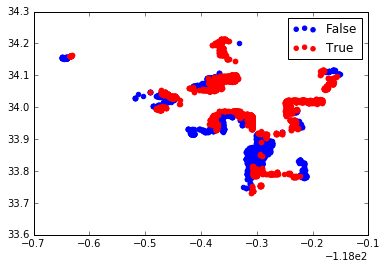

In [84]:
for label, group in df_sub[['x', 'y', 'in_la']].groupby('in_la'): 
    color = 'blue'
    if label:
        color = 'red'
    plt.scatter(group.x, group.y, label = label, color=color)
    
plt.legend(loc= 'best')

In [85]:
print("Number of locations in LA: %d" %df_sub.in_la.sum())
print("NUmber of loactions outside of LA: %d" %(df_sub.shape[0]-df_sub.in_la.sum()))

Number of locations in LA: 3352
NUmber of loactions outside of LA: 3121


## Model 1:
1. log(price_per_sqft) ~ LA + 2005*LA + 2006*LA + ... 2012*LA and variations on time span

In [86]:
form1 = 'np.log(price_per_)~' + "+".join(['in_la*yr'+str(n) for n in range(2005,2013)])
form1 = form1 + "+" + "+".join(['yr'+str(y) for y in range(2000,2005)])
print(form1)

np.log(price_per_)~in_la*yr2005+in_la*yr2006+in_la*yr2007+in_la*yr2008+in_la*yr2009+in_la*yr2010+in_la*yr2011+in_la*yr2012+yr2000+yr2001+yr2002+yr2003+yr2004


In [87]:
result = sm.ols(formula=form1, data=df_sub).fit()
print(result.summary())

with open("/".join([data_path,"model1.tex"]), 'w+') as f:
    f.write(re.sub("_", "\_",result.summary().as_latex()))

                            OLS Regression Results                            
Dep. Variable:     np.log(price_per_)   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     30.91
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          9.13e-123
Time:                        23:54:28   Log-Likelihood:                -11001.
No. Observations:                6473   AIC:                         2.205e+04
Df Residuals:                    6450   BIC:                         2.220e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                4.1271 

## Model 2:
log(price_per_sqft) ~ 1_variables + rooms+unit_stories+living_area_sqft+lot_size + (census tract level fixed effects)

In [88]:
#,'yrbuilt','lot_size'#'baths','bedrooms','rooms','stories','units',
form2 = form1 +'+' +"+".join(['baths','bedrooms','rooms','stories','units'])

In [89]:
#fit the above model
result = sm.ols(formula=form2, data=df_sub).fit()
print(result.summary())
with open("/".join([data_path, 'model2.tex']), 'w+') as f:
    f.write(re.sub("_", "\_",result.summary().as_latex()))

                            OLS Regression Results                            
Dep. Variable:     np.log(price_per_)   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     25.92
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          5.99e-123
Time:                        23:54:59   Log-Likelihood:                -10992.
No. Observations:                6473   AIC:                         2.204e+04
Df Residuals:                    6445   BIC:                         2.223e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                4.1189 

## Model 3
log(price_per_sqft) - 2_variables + pop_size + median_income + college_educatd + poverty + race + homeownership

#### Note: For the above, I load an augmented dataset

In [90]:
## data prep:
df = pd.read_csv("/".join([data_path,"transactions_acs.csv"]))
df = df[(df.transyear >= 2000) & (df.transyear<2010)]
df['in_la'] = df.addr_city == 'LOS ANGELES'

df.addr_city = df.addr_city.str.title()
df['combo'] = df[['city_name', 'addr_city']].apply(lambda s: "-".join(s), axis=1)

df['la-other'] = (df['addr_city'] == 'Los Angeles')
df['other-other'] = (df['addr_city'] == df['city_name'])
df['combo_bool'] = df['la-other'] | df['other-other']

yr_dummies = pd.get_dummies(df.transyear)
yr_dummies.columns = 'yr'+yr_dummies.columns.astype(str)
df = pd.concat([df,yr_dummies],axis=1)

In [91]:
#find cities that are in the ACS and transactions data after 2000 (year of Census which samples at all locations)
acs_cities = df.loc[(~df.place.isnull()) & (df.transyear>=2000),'addr_city'].unique()[1:]

acs_cities_la = [s+"-Los Angeles" for s in acs_cities]

In [92]:
#subsample as before but now utilizing the acs cities
conds_indx_out = (df.Distance_1 <= 1000) & (df.Distance<=1000) & (df.price_per_  > 1) & (df.price_per_<5000) & (df.price_per_.notnull()) & (df.place.notnull()) & (df.addr_city.str.contains("|".join(acs_cities)))
conds_indx_in = (df.Distance_1 <= 1000) & (df.Distance<=1000) & (df.price_per_  > 1) & (df.price_per_<5000) & (df.price_per_.notnull()) & (df.place.notnull())  & (df.combo.str.contains('|'.join(acs_cities_la)))

conds_indx = conds_indx_out | conds_indx_in

print("City combos available after elimination")
print((df.combo)[conds_indx].unique())

df_sub = df[conds_indx]
df_sub = df_sub[~df_sub.addr_city.str.contains("Compton|South Pasadena")]

City combos available after elimination
['Hidden Hills-Calabasas' 'Rancho Palos Verdes-Los Angeles'
 'Rancho Palos Verdes-Rancho Palos Verdes' 'Lomita-Lomita'
 'Lomita-Los Angeles' 'Long Beach-Los Angeles' 'Long Beach-Long Beach'
 'Carson-Los Angeles' 'Carson-Torrance' 'Carson-Carson' 'Carson-Gardena'
 'Carson-Long Beach' 'Torrance-Torrance' 'Torrance-Los Angeles'
 'Gardena-Torrance' 'Gardena-Gardena' 'Gardena-Los Angeles'
 'Compton-Los Angeles' 'Compton-Compton' 'El Segundo-El Segundo'
 'El Segundo-Inglewood' 'Hawthorne-Inglewood' 'Hawthorne-Los Angeles'
 'Hawthorne-Hawthorne' 'Lynwood-Los Angeles' 'Lynwood-South Gate'
 'Lynwood-Lynwood' 'South Gate-Los Angeles' 'South Gate-South Gate'
 'Inglewood-Inglewood' 'Inglewood-Los Angeles'
 'Huntington Park-Los Angeles' 'Huntington Park-Huntington Park'
 'Huntington Park-Vernon' 'Vernon-Vernon' 'Vernon-Los Angeles'
 'Commerce-Los Angeles' 'Santa Monica-Los Angeles'
 'Santa Monica-Santa Monica' 'Monterey Park-Los Angeles'
 'West Hollywood-Los 

In [93]:
cities_w_trans = ['burbank','inglewood', 'long beach','santa monica','torrance']
pd.get_dummies(df_sub.place)[cities_w_trans]
df_sub = pd.concat([df_sub,pd.get_dummies(df_sub.place)[cities_w_trans]], axis=1)
df_sub.columns = df_sub.columns.str.replace(" ", "_")

Number of locations in LA: 2359
NUmber of loactions outside of LA: 1673
Number of sample points: 4032


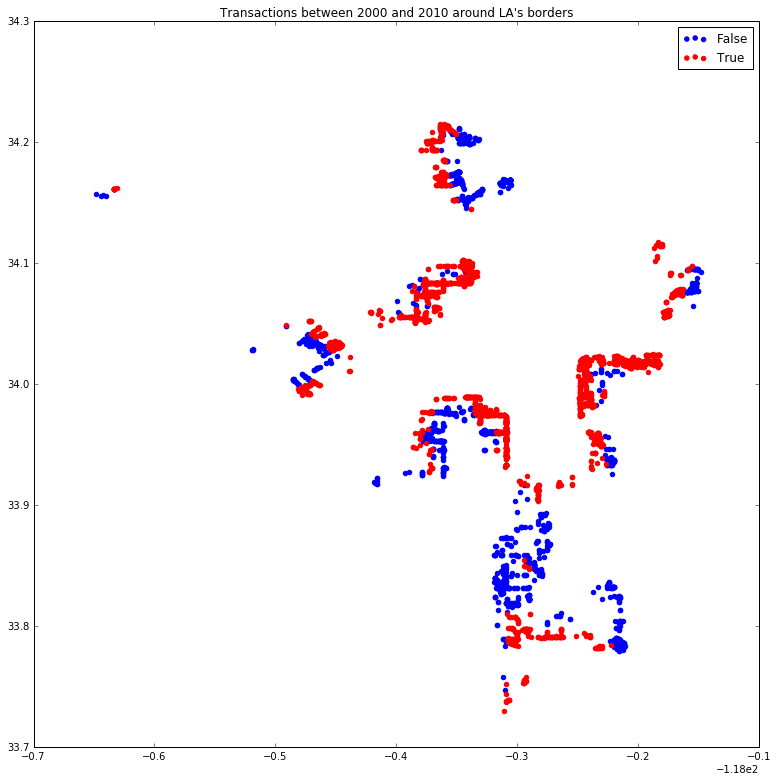

In [94]:
fig, ax = plt.subplots(figsize = (13,13))
for label, group in df_sub[['x', 'y', 'in_la']].groupby('in_la'): 
    color = 'blue'
    if label:
        color = 'red'
    plt.scatter(group.x, group.y, label = label, color=color)
    
plt.legend(loc= 'best')
plt.title("Transactions between 2000 and 2010 around LA's borders")
plt.savefig("/".join([data_path, 'reduced_LA_map.png']))

print("Number of locations in LA: %d" %df_sub.in_la.sum())
print("NUmber of loactions outside of LA: %d" %(df_sub.shape[0]-df_sub.in_la.sum()))
print("Number of sample points: %d" %(df_sub.shape[0]))

In [95]:
form1 = 'np.log(price_per_)~' + "+".join(['in_la*yr'+str(n) for n in range(2005,2010)])
form1 = form1 + "+" + "+".join(['yr'+str(y) for y in range(2001,2005)])
form2 = form1 +'+' +"+".join(['baths','bedrooms','rooms','stories','units'])

In [96]:
##create the formula ,'prop_white','median_household_income',
demo_vars = ['prop_asian', 'prop_black','prop_college_edu','poverty_rate', 'ownership_rate',
             'np.log(total_population)']
form3 = form2+ "+" + "+".join(demo_vars)
form3

'np.log(price_per_)~in_la*yr2005+in_la*yr2006+in_la*yr2007+in_la*yr2008+in_la*yr2009+yr2001+yr2002+yr2003+yr2004+baths+bedrooms+rooms+stories+units+prop_asian+prop_black+prop_college_edu+poverty_rate+ownership_rate+np.log(total_population)'

In [97]:
#fit the above model
result = sm.ols(formula=form3, data=df_sub).fit()#cov_type='cluster',cov_kwds={'groups':df_sub['place']})
print(result.summary())
with open("/".join([data_path, 'model3.tex']), 'w+') as f:
    f.write(re.sub("_", "\_",result.summary().as_latex()))

                            OLS Regression Results                            
Dep. Variable:     np.log(price_per_)   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     31.75
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          6.24e-142
Time:                        23:58:38   Log-Likelihood:                -6468.8
No. Observations:                4032   AIC:                         1.299e+04
Df Residuals:                    4005   BIC:                         1.316e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

In [98]:
form4 = form3 + "+"+"+".join([re.sub(" ", '_',s) for s in  cities_w_trans ])
form4

'np.log(price_per_)~in_la*yr2005+in_la*yr2006+in_la*yr2007+in_la*yr2008+in_la*yr2009+yr2001+yr2002+yr2003+yr2004+baths+bedrooms+rooms+stories+units+prop_asian+prop_black+prop_college_edu+poverty_rate+ownership_rate+np.log(total_population)+burbank+inglewood+long_beach+santa_monica+torrance'

In [99]:
#fit the above model
result = sm.ols(formula=form4, data=df_sub).fit()#cov_type='cluster',cov_kwds={'groups':df_sub['place']})
print(result.summary())
with open("/".join([data_path, 'model4.tex']), 'w+') as f:
    f.write(re.sub("_", "\_",result.summary().as_latex()))

                            OLS Regression Results                            
Dep. Variable:     np.log(price_per_)   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     27.71
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          3.04e-144
Time:                        23:58:56   Log-Likelihood:                -6454.3
No. Observations:                4032   AIC:                         1.297e+04
Df Residuals:                    4000   BIC:                         1.317e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

## Models 5 - pairwise differences (contiguous area differences)
- without ACS data, we can leverage a larger sample
- ACS data will serve as a robustness check. 

In [69]:
[s for s in pair_col_titles if (s!= 'ElSePair') & (s!= "CalaPair")]

['LomiPair',
 'TorrPair',
 'BevePair',
 'InglPair',
 'WestPair',
 'HawtPair',
 'GardPair',
 'SantPair']

In [82]:
form1 = 'np.log(price_per_)~' + "+".join(['in_la*yr'+str(n) for n in range(2005,2012)])
form1 = 'np.log(price_per_)~' + "+" + 'in_la*after04'
#form1 = form1 + "+" + "+".join(['yr'+str(y) for y in range(2002,2005)])
#,'yrbuilt','lot_size'#'baths','bedrooms','rooms','stories','units',
form2 = form1 +'+' +"+".join(['baths','bedrooms','rooms','stories','units'])
pair_interactions = ['yr'+str(yr)+":"+pair for pair in [s for s in pair_col_titles if (s!= 'ElSePair') & (s!= "CalaPair")] for yr in range(2002,2012)]

#"+".join(['*yr'+str(n) for n in range(2005,2013)])
form5 = form2 + '+'+"+".join(pair_interactions)
print("number of covars: %d" %len(form5.split("+")))
print(form5)

number of covars: 87
np.log(price_per_)~+in_la*after04+baths+bedrooms+rooms+stories+units+yr2002:LomiPair+yr2003:LomiPair+yr2004:LomiPair+yr2005:LomiPair+yr2006:LomiPair+yr2007:LomiPair+yr2008:LomiPair+yr2009:LomiPair+yr2010:LomiPair+yr2011:LomiPair+yr2002:TorrPair+yr2003:TorrPair+yr2004:TorrPair+yr2005:TorrPair+yr2006:TorrPair+yr2007:TorrPair+yr2008:TorrPair+yr2009:TorrPair+yr2010:TorrPair+yr2011:TorrPair+yr2002:BevePair+yr2003:BevePair+yr2004:BevePair+yr2005:BevePair+yr2006:BevePair+yr2007:BevePair+yr2008:BevePair+yr2009:BevePair+yr2010:BevePair+yr2011:BevePair+yr2002:InglPair+yr2003:InglPair+yr2004:InglPair+yr2005:InglPair+yr2006:InglPair+yr2007:InglPair+yr2008:InglPair+yr2009:InglPair+yr2010:InglPair+yr2011:InglPair+yr2002:WestPair+yr2003:WestPair+yr2004:WestPair+yr2005:WestPair+yr2006:WestPair+yr2007:WestPair+yr2008:WestPair+yr2009:WestPair+yr2010:WestPair+yr2011:WestPair+yr2002:HawtPair+yr2003:HawtPair+yr2004:HawtPair+yr2005:HawtPair+yr2006:HawtPair+yr2007:HawtPair+yr2008:HawtPai

In [83]:
#fit the above model
result = sm.ols(formula=form5, data=df_sub).fit()
print(result.summary())
with open("/".join([data_path, 'model5.tex']), 'w+') as f:
    f.write(re.sub("_", "\_",result.summary().as_latex()))

                            OLS Regression Results                            
Dep. Variable:     np.log(price_per_)   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     17.18
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          5.67e-226
Time:                        23:39:02   Log-Likelihood:                -10645.
No. Observations:                6473   AIC:                         2.147e+04
Df Residuals:                    6385   BIC:                         2.206e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 4.03

In [33]:
pairDums.columns

Index(['HiddPair', 'RancPair', 'LomiPair', 'LongPair', 'CarsPair', 'TorrPair',
       'GardPair', 'CompPair', 'ElSPair', 'HawtPair', 'LynwPair', 'SoutPair',
       'InglPair', 'HuntPair', 'BellPair', 'VernPair', 'CommPair', 'MontPair',
       'SantPair', 'MaliPair', 'WestPair', 'AlhaPair', 'BevePair', 'CalaPair',
       'BurbPair'],
      dtype='object')

In [25]:
set([s+"-Los Angeles" for s in cities_w_data4all]).intersection(pair_city_list)

{'Beverly Hills-Los Angeles',
 'Calabasas-Los Angeles',
 'El Segundo-Los Angeles',
 'Gardena-Los Angeles',
 'Hawthorne-Los Angeles',
 'Inglewood-Los Angeles',
 'Lomita-Los Angeles',
 'Santa Monica-Los Angeles',
 'Torrance-Los Angeles',
 'West Hollywood-Los Angeles'}

In [26]:
set([re.sub("-Los Angeles", "", s) for s in pair_city_list]).intersection(cities_w_data4all)

{'Beverly Hills',
 'Calabasas',
 'El Segundo',
 'Gardena',
 'Hawthorne',
 'Inglewood',
 'Lomita',
 'Santa Monica',
 'Torrance',
 'West Hollywood'}